In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from arbitragelab.ml_approach.filters import *

import warnings
warnings.filterwarnings('ignore')

In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
wti_gas_df = pd.read_csv('./data/wti_gas.csv').set_index('date')
wti_gas_df.index = pd.to_datetime(wti_gas_df.index) 

wti_gas_paper_df = wti_gas_df['1995-01': '2003-04']
wti_gas_paper_df

In [4]:
df_spread = pd.read_csv('./data/tar_residual_gas_wti.csv').set_index('date')
df_spread.index = pd.to_datetime(df_spread.index) 
df_spread.columns = ['tar_spread_resid']

In [5]:
working_df = pd.concat([wti_gas_paper_df, df_spread], axis=1)
working_df.dropna(inplace=True)

In [6]:
spread_series = working_df['tar_spread_resid']
spread_std = spread_series.std()

spread_diff_series = spread_series.diff()
spread_diff_std = spread_diff_series.std()

# Threshold Filter (based on Standard Deviation)

The threshold filter $X$ is as follows;
- if $\Delta S_t > X$ then go, or stay, long the spread
- if $\Delta S_t < X$ then go, or stay, short the spread
- if $-X < \Delta S_t < X$ then stay out of the spread

where $\Delta S_t$ is the change in spread and $X$ is the level of the filter.

In [7]:
std_events = get_events_by_threshold_filter(spread_diff_series, -spread_diff_std*2, spread_diff_std*2)
std_events['side'].value_counts()

 0.0    1983
-1.0      53
 1.0      45
Name: side, dtype: int64

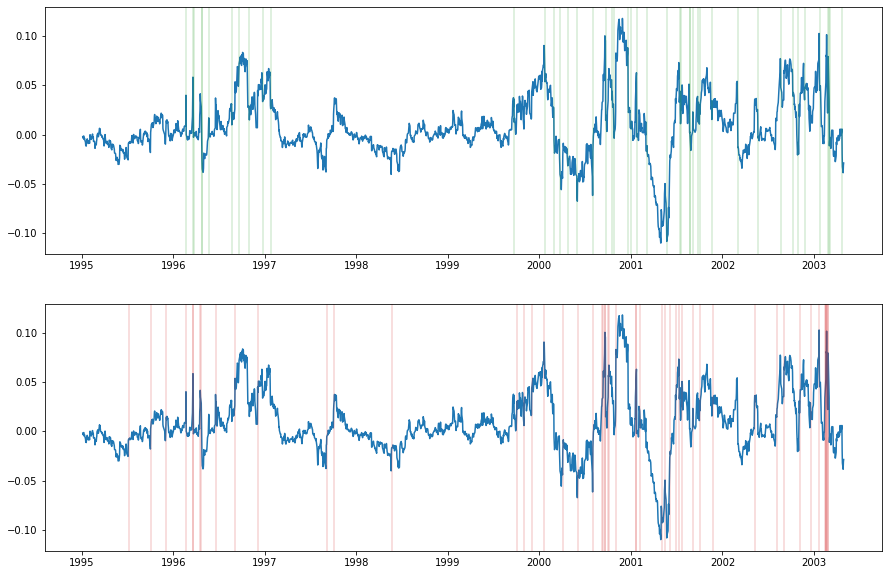

In [8]:
plot_events(std_events)

# Asymmetric Threshold Filter

The threshold filter $X$ is as follows;
- if $\Delta S_t > \vert p_1 \vert * X$ then go, or stay, long the spread
- if $\Delta S_t < - \vert p_2 \vert * X$ then go, or stay, short the spread
- if $- \vert p_2 \vert * X < \Delta S_t < \vert p_1 \vert * X$ then stay out of the spread

where $\Delta S_t$ is the change in spread, $X$ is the level of the filter and $(p_1, p_2)$ being coefficients estimated from the TAR model.

In [9]:
# Values as set in the paper.
p_1 = -0.012957
p_2 = -0.038508

asym_events = get_events_by_asym_filter(spread_diff_series, -spread_diff_std*2, spread_diff_std*2, p_1, p_2)
asym_events['side'].value_counts()

 1.0    985
-1.0    908
 0.0    188
Name: side, dtype: int64

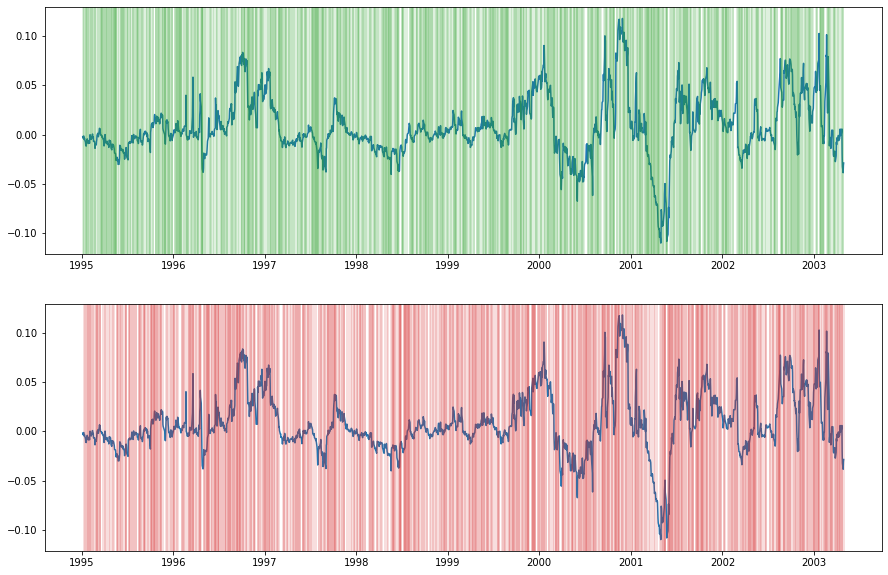

In [10]:
plot_events(asym_events)

# Correlation Filter (based on Dunis et al.)

Formally, the correlation filter $X_c$ can be written as;
- if $\Delta C < X_c$ then take the decision of the trading rule
- if $\Delta C > X_c$ then stay out of the market

where $\Delta C$ is the change in correlation and $X_c$ being the size of the correlation filter.

In [11]:
corr_events = get_events_by_corr_filter( working_df[['wti', 'gasoline']], buy_threshold=0.05, sell_threshold=-0.05 )
corr_events['side'].value_counts()

 0.0    1887
-1.0     106
 1.0      88
Name: side, dtype: int64

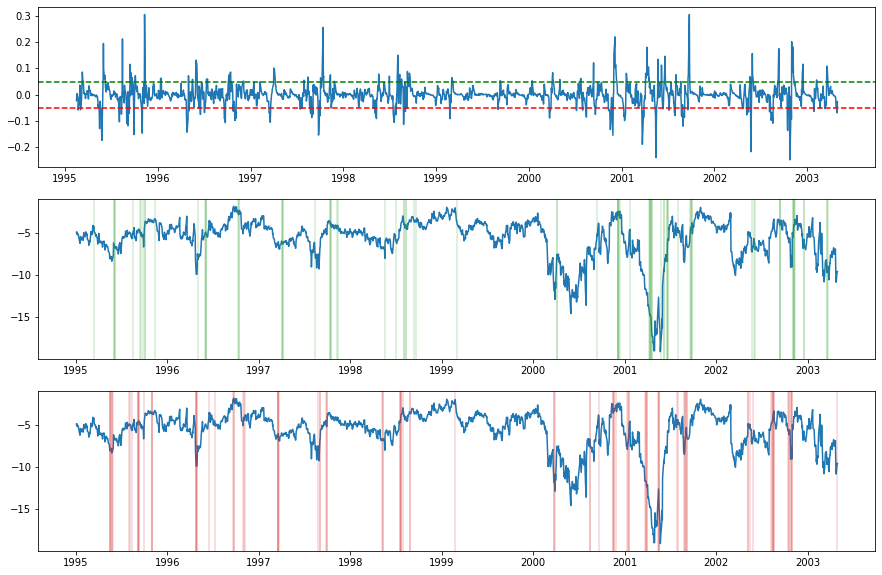

In [12]:
plot_corr( working_df[['wti', 'gasoline']], buy_threshold=0.05, sell_threshold=-0.05 )

# CUSUM Correlation Filter

@ To Do

In [197]:
cusum_corr_events = get_events_by_cusum_corr_filter( working_df[['wti', 'gasoline']] )
cusum_corr_events['side'].value_counts()

 0.0    1642
 1.0     277
-1.0     163
Name: side, dtype: int64

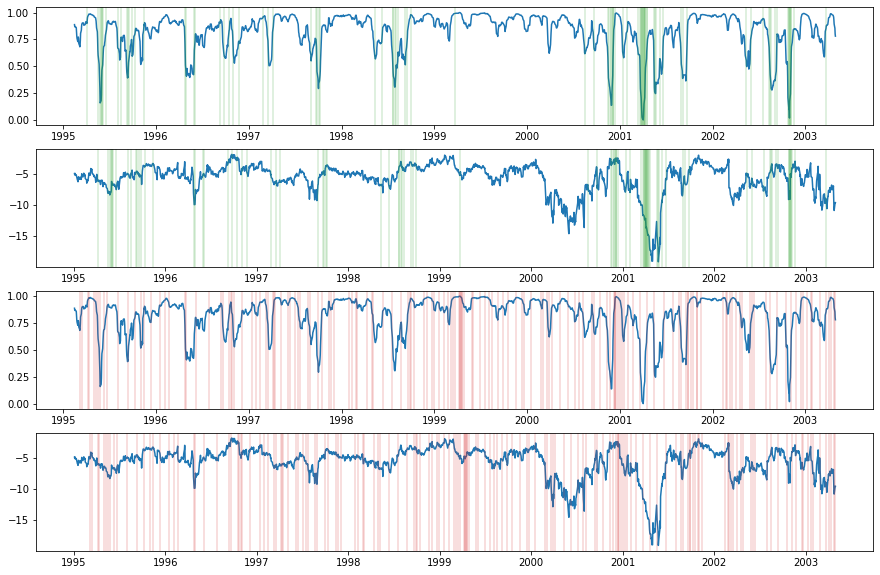

In [136]:
plot_corr_cusum(working_df[['wti', 'gasoline']], buy_threshold=0.3, sell_threshold=0.9)